# Problem formulation

The problem we have focused on is predicting the global temperature anomaly based on concentration of gases in the atmosphere. Data is collected from year 2001 to 2022. 
<br> <br> The result of our research can show directly how the global warming is going to change in the future years. This information can be useful for preparing society for the impact of temperature changes. It can also show how our population influence global weather changes because of gases emission.<br> <br>
Data used in our project come from two different sources. Data about global temperature anomaly comes from NASA Global Climate Change https://climate.nasa.gov/vital-signs/global-temperature/ and the gases concentration comes from Global Monitoring Laboratory https://gml.noaa.gov/. The first one contains yearly temperature anomaly around the globe. Originally data was in year range 1880-2023. The second data set has information about three gases concentration in the atmosphere. It not only has yearly data but also monthly.
<br> <br>
Before starting the project we created the dag graph that shows what data impacts global warming. 
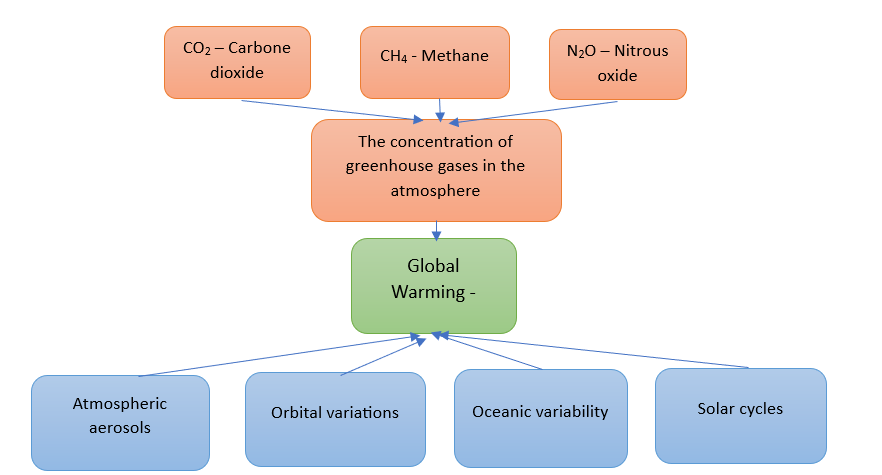. <br> The parameters we have taken into consideration are carbon dioxide(CO2), methan(CH4), nitrous oxide(N2O). Although there were more factors than only gases the ones we have chosen had the most impact on changes in the temperature. <br><br>

# Data preprocessing

As the data were clear without any NaN or Null values we didn't change much while cleaning it. We had to compute the mean value for every year when it comes to gases because the data had values for every month which we didn't need to use. 

### Imports

In [69]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("root/data/data_preprocessed/data.csv", index_col=0)

### Data standarization

In [70]:
df.head()

,year,CO2,CH4,N2O,Temperature
0,2001,371.319167,1771.269167,316.364167,0.54
1,2002,373.452500,1772.731667,316.942500,0.63
2,2003,375.983333,1777.334167,317.631667,0.62
3,2004,377.698333,1776.995833,318.262500,0.53
4,2005,379.983333,1774.180000,318.920000,0.68


In [71]:
df.describe()

,year,CO2,CH4,N2O,Temperature
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2011.500000,394.154091,1817.905000,325.018220,0.744091
std,6.493587,14.618055,43.282048,5.969065,0.158284
min,2001.000000,371.319167,1771.269167,316.364167,0.530000
25%,2006.250000,382.574375,1778.368750,319.980625,0.632500
50%,2011.500000,392.953333,1805.632917,324.638333,0.680000
75%,2016.750000,406.171875,1848.098542,329.547083,0.887500
max,2022.000000,418.564167,1911.968333,335.662500,1.020000


Data was standarized using StandardScaler class form sklearn. We wanted to have our parameters in the similar range and in not so big scale as they were before 

In [72]:
scaler = StandardScaler()
df[['CO2', 'CH4', 'N2O']] = scaler.fit_transform(df[['CO2', 'CH4', 'N2O']])

print(df)

    year       CO2       CH4       N2O  Temperature
0   2001 -1.598865 -1.102843 -1.483935         0.54
1   2002 -1.449492 -1.068258 -1.384767         0.63
2   2003 -1.272287 -0.959418 -1.266593         0.62
3   2004 -1.152206 -0.967419 -1.158423         0.53
4   2005 -0.992214 -1.034008 -1.045679         0.68
5   2006 -0.844650 -1.015326 -0.890782         0.64
6   2007 -0.709223 -0.861555 -0.782897         0.67
7   2008 -0.582723 -0.728771 -0.602136         0.54
8   2009 -0.455931 -0.575395 -0.469245         0.66
9   2010 -0.283744 -0.448149 -0.312204         0.73
10  2011 -0.161270 -0.348670 -0.137302         0.61
11  2012 -0.006880 -0.231750  0.007021         0.65
12  2013  0.180886 -0.105253  0.159489         0.68
13  2014  0.326174  0.114358  0.355969         0.75
14  2015  0.480156  0.389186  0.541731         0.90
15  2016  0.718277  0.598510  0.674336         1.02
16  2017  0.882529  0.752518  0.810657         0.92
17  2018  1.019531  0.934489  1.010995         0.85
18  2019  1.

In [ ]:
#TODO Alternative standarization way
df['CO2'] /= 100
df['CH4'] /= 1000
df['N2O'] /= 100

df['CO2_centred'] = df['CO2'] - df['CO2'].mean()
df['CH4_centred'] = df['CH4'] - df['CH4'].mean()
df['N2O_centred'] = df['N2O'] - df['N2O'].mean()
df

#### Checking id data is suitable for normal model

In [68]:

normality_test = stats.normaltest(np.array(df['Temperature']))

# Wyświetlanie wyników testu
print("Statystyka testu: ", normality_test.statistic)
print("Wartość p-wartości: ", normality_test.pvalue)

# Sprawdzenie interpretacji wyników testu
alpha = 0.05
if normality_test.pvalue < alpha:
    print("Dane nie pochodzą z rozkładu normalnego")
else:
    print("Dane są zgodne z rozkładem normalnym")

Statystyka testu:  3.3440751699526974
Wartość p-wartości:  0.18786388675829657
Dane są zgodne z rozkładem normalnym


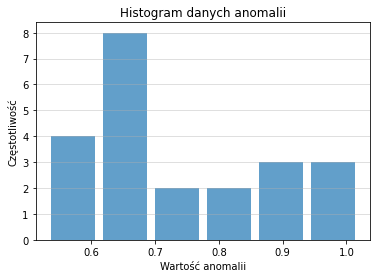

In [10]:
plt.hist(np.array(df['Temperature']), bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Anomaly value')
plt.ylabel('Frequency')
plt.title('Histogram of anomaly data')
plt.show()

From histogram above we can see that the data doesn't have strong resemblance for any of distributions. At first we thought about Gamma distribution but after some actions the results weren't satisfying so we decided to go with  Normal Distribution

___________________________________________________________________________________

In [ ]:
#TODO MAYBE TO DELETE THIS LATER 

### 1. Model with one predictor CO2

#### 1.1. Prior predictive

In [16]:
# 1.Prepare data to simulation
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df))}

In [19]:
%%writefile root/stan_files/temp1_ppc.stan
data {
  int<lower=0> N;
  vector[N] CO2;
}

generated quantities {
  real alpha = normal_rng(0.7, 0.1);
  real beta = normal_rng(0, 0.1);
  real sigma = normal_rng(0.1, 0.01);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = normal_rng(alpha + beta * CO2[i], sigma);
  }
}

Overwriting root/stan_files/temp1_ppc.stan


In [20]:
# 3.Simulate model
model_ppc=CmdStanModel(stan_file='root/stan_files/temp1_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp1_ppc.stan to exe file /root/stan_files/temp1_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [21]:
# 4. Show the output
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,temperature[1],temperature[2],temperature[3],temperature[4],temperature[5],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
0,0.0,0.0,0.970817,0.077718,0.087277,0.857692,0.737534,0.892526,0.987906,1.093240,...,1.138400,0.989289,0.966479,1.055010,1.036150,1.064790,1.122710,1.156990,1.070680,1.112080
1,0.0,0.0,0.529279,0.009829,0.093506,0.623978,0.501744,0.501701,0.577937,0.559942,...,0.556208,0.430328,0.632708,0.645513,0.714393,0.683831,0.565736,0.413707,0.494175,0.520632
2,0.0,0.0,0.776375,0.028530,0.106436,0.603151,0.734533,0.739354,0.873548,0.829582,...,0.936888,0.706590,0.846800,0.858664,0.900230,0.864502,0.779811,0.854443,0.813030,0.683235
3,0.0,0.0,0.771675,0.176019,0.096653,0.304587,0.553828,0.556891,0.482651,0.704013,...,0.640216,0.754173,0.996055,0.824022,0.905706,1.027550,1.247690,1.014700,0.957791,1.057360
4,0.0,0.0,0.604735,0.051550,0.089588,0.513374,0.647294,0.531755,0.508422,0.452786,...,0.429255,0.647635,0.434060,0.589641,0.573707,0.683580,0.531127,0.585656,0.784834,0.648717


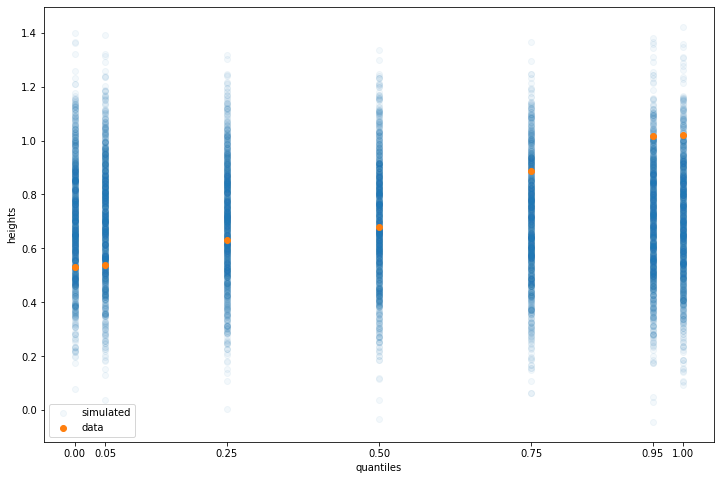

In [22]:
# 5. Plot data
temperature = ppc_df.loc[:, 'temperature[1]':'temperature[22]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(temperature, q, axis=1)
data_quantiles = np.quantile(df.Temperature, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.legend()
plt.show()

#### 1.2. Fitting model to data

In [24]:

%%writefile root/stan_files/temp2_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] co2;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
      mean[i] = alpha + beta * co2[i];
  }
}

model {
    alpha ~ normal(0.7, 0.1);
    sigma ~ normal(0.1, 0.01);
    beta ~ normal(0, 0.1);
    for (i in 1:N) {
      temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
    }
}

Overwriting root/stan_files/temp2_ppc.stan


In [25]:
# 2. Create model
model_2_fit=CmdStanModel(stan_file='root/stan_files/temp2_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/stan_files/temp2_ppc.stan to exe file /root/stan_files/temp2_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp2_ppc


In [26]:
# 3. Prepare data for the model
N = len(df)
data_fit = {'N': N, 'co2': df.CO2.values[:N], 'temp': df.Temperature.values[:N]}

In [27]:
# 4. Simulate model
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [28]:
# 5. Show the output
df_ = fit.draws_pd()
df_.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,temp_[13],temp_[14],temp_[15],temp_[16],temp_[17],temp_[18],temp_[19],temp_[20],temp_[21],temp_[22]
0,36.3087,0.840087,0.863724,3.0,7.0,0.0,-35.9433,0.748787,0.079886,0.148199,...,0.763650,0.732414,0.917115,0.827587,0.846806,0.764573,0.916291,0.975182,1.123170,0.999268
1,37.3812,1.000000,0.863724,2.0,3.0,0.0,-35.8637,0.732477,0.103721,0.113797,...,0.828513,0.632898,0.844518,0.927355,0.802949,0.641469,0.848376,0.828741,0.858709,0.836860
2,37.9786,1.000000,0.863724,2.0,3.0,0.0,-37.2839,0.752578,0.094373,0.117044,...,0.678710,0.962620,0.822998,0.840761,0.804226,0.987062,1.022130,0.925154,0.919109,0.921474
3,37.3556,0.935091,0.863724,2.0,3.0,0.0,-37.1721,0.723274,0.095984,0.150012,...,0.756080,0.594884,0.808320,0.871443,0.965194,1.056340,0.864628,0.891705,1.017130,0.869015
4,37.8294,0.854378,0.863724,2.0,3.0,0.0,-36.1775,0.745023,0.096027,0.149959,...,0.869452,0.728951,0.800453,0.798568,0.775836,1.142170,1.022030,1.004690,1.079750,1.062140


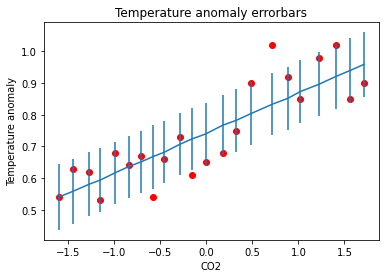

In [30]:
# 6. Plot results
temperature = df_.loc[:, 'temp_[1]':f'temp_[{N}]'].values
y = temperature.mean(axis=0)
x = data_fit['co2']
yerr = temperature.std(axis=0)

plt.scatter(x, df['Temperature'], color = 'red')
plt.errorbar(x, y, yerr)
plt.xlabel('CO2')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly errorbars')
plt.show()

_________________________________________________________

# Model 1 - Normal Distribution

Our first approach is creating model with Normal Distribution. It is characterized by its symmetric bell shaped curve. It is defined by two parameters mean and standard deviation. It is symmetric around mean value that means that mean represents  center of distribution while the standard deviation determines the spread of the data. <br> <br> 
On below plots we can see that correlation between our parameters and temperature data can be considered to be linear and that is why we have chosen this approach in the model. <br> <br> Standard Bayesian model: $outcome_{i}$ ~ Normal($\mu_{i}$, $\sigma$)
    $\mu_{i}$ = $\alpha$+ $\beta$ * $predictor_{i}$
    $\alpha$ ~ Normal(a,b)
    $\beta$ ~ Normal(c,d)
    $\sigma$ ~ Normal(f,g)

As we have three predictors the sum of multiplications beta and predictors is added two more times to the equation.

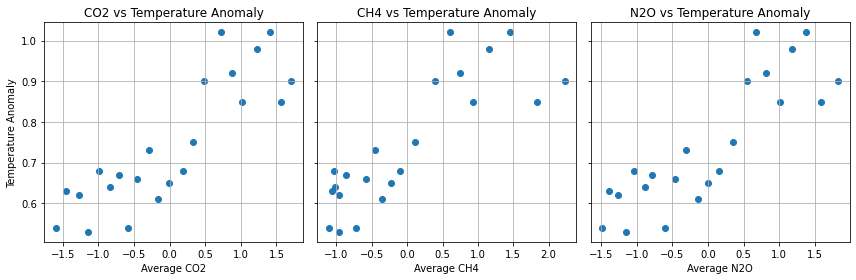

In [73]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axs[0].scatter(df['CO2'], df['Temperature'])
axs[0].set_xlabel('Average CO2')
axs[0].set_ylabel('Temperature Anomaly')
axs[0].set_title('CO2 vs Temperature Anomaly')
axs[0].grid()

axs[1].scatter(df['CH4'], df['Temperature'])
axs[1].set_xlabel('Average CH4')
axs[1].set_title('CH4 vs Temperature Anomaly')
axs[1].grid()

axs[2].scatter(df['N2O'], df['Temperature'])
axs[2].set_xlabel('Average N2O')
axs[2].set_title('N2O vs Temperature Anomaly')
axs[2].grid()

plt.tight_layout()
plt.show()

## Prior

Alpha is normal distribution is based on the mean value of Temperature anomaly in the data set and sigma is based on standard deviation od the same data. Beta for every predictor and sigma is also normal distribution. The parameters for distribution of beta where chosen considering the output of this prior model. It was the most difficult challenge to  fir beta parameters properly. 

In [74]:
%%writefile root/stan_files/temp3_ppc.stan
data {
  int<lower=0> N;
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
}

generated quantities {
  real alpha = normal_rng(0.7, 0.1);
  real beta_CO2 = normal_rng(0, 0.1);
  real beta_CH4 = normal_rng(0, 0.1);
  real beta_N2O = normal_rng(0, 0.1);
  real sigma = normal_rng(0.1, 0.02);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = normal_rng(alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i], sigma);
  }
}


Overwriting root/stan_files/temp3_ppc.stan


In [75]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df)),'CH4':np.linspace(df.CH4.min(),df.CH4.max(),len(df)),'N2O':np.linspace(df.N2O.min(),df.N2O.max(),len(df))}
model_ppc2=CmdStanModel(stan_file='root/stan_files/temp3_ppc.stan')
R = 1000
sim=model_ppc2.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp3_ppc.stan to exe file /root/stan_files/temp3_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp3_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [76]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta_CO2,beta_CH4,beta_N2O,sigma,temperature[1],temperature[2],temperature[3],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
0,0.0,0.0,0.970817,0.077718,-0.127227,0.012759,0.072212,0.985710,1.048590,1.119710,...,0.854489,0.911704,0.880068,0.887731,0.919615,0.931942,0.844500,0.862722,0.726557,0.851031
1,0.0,0.0,0.635055,0.118083,-0.014296,-0.015998,0.112775,0.534230,0.179542,0.630123,...,0.863881,0.838968,0.708483,0.537071,0.646070,0.689926,0.820564,0.780421,0.834648,0.640667
2,0.0,0.0,0.699322,-0.000371,0.121486,0.075957,0.114794,0.588463,0.623650,0.606261,...,0.792784,0.899589,0.881236,0.767561,1.034040,1.184980,0.975659,0.824738,1.118990,1.120850
3,0.0,0.0,0.606081,0.106421,-0.002303,0.037027,0.088234,0.462742,0.446727,0.355780,...,0.570904,0.658725,0.610738,0.762513,0.647393,0.752692,0.898824,0.799267,0.790523,0.749964
4,0.0,0.0,0.577813,0.141649,-0.018822,-0.016031,0.112103,0.440043,0.511638,0.191112,...,0.558346,0.491609,0.602761,0.621372,0.716101,0.585402,0.747984,0.789003,0.786724,0.607919


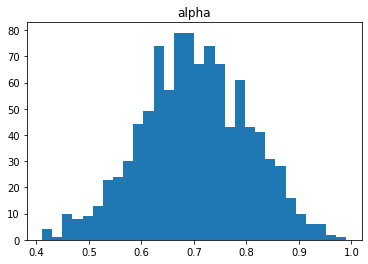

In [84]:
plt.hist(ppc_df['alpha'], bins=30)
plt.title('alpha')
plt.show()

Parameter alpha is in the right range and is wider on the center which is good.

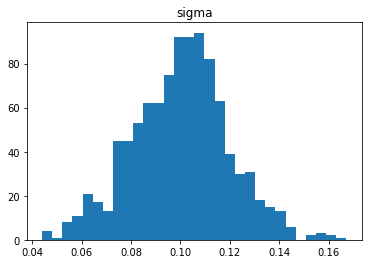

In [85]:
plt.hist(ppc_df['sigma'], bins=30)
plt.title('sigma')
plt.show()

Parameter sigma looks also okay with tha values at the meant range

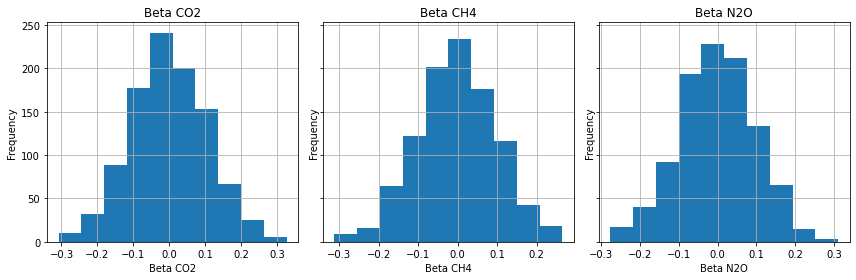

In [87]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axs[0].hist(ppc_df['beta_CO2'])
axs[0].set_xlabel('Beta CO2')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Beta CO2')
axs[0].grid()

axs[1].hist(ppc_df['beta_CH4'])
axs[1].set_xlabel('Beta CH4')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Beta CH4')
axs[1].grid()

axs[2].hist(ppc_df['beta_N2O'])
axs[2].set_xlabel('Beta N2O')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Beta N2O')
axs[2].grid()

plt.tight_layout()
plt.show()

As we put the same values for beta distribution parameters for predictors they histograms look almost the same. We wanted for all the predictors to have the same impact on our model. 

Text(80, 20, 'min')

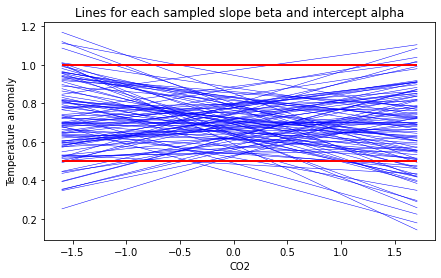

In [78]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim.stan_variable('beta_CO2')
alpha_humid = sim.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.hlines([0.5, 1],xmin = df['CO2'].min(), xmax = df['CO2'].max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

This model fits just fine. Those lines that are under or above min and max values on the plot are acceptable because temperature anomaly can go below 0.5 (even below 0) and above 1. After fitting the data to the model everything should be between those lines perfectly. 

Lets see how the actual temperature data corresponds with the data from prior.

Text(80, 20, 'min')

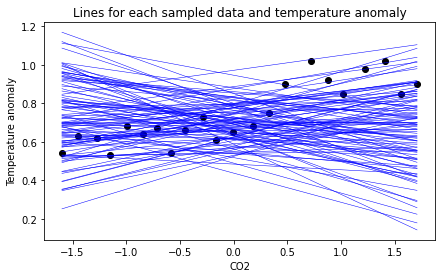

In [81]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim.stan_variable('beta_CO2')
alpha_humid = sim.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

## Posterior predictive check

##### Fitting model to data

In [82]:
%%writefile root/stan_files/temp4_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] CO2;
    vector[N] CH4;
    vector[N] N2O;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta_CO2;
    real<lower=0> beta_CH4;
    real<lower=0> beta_N2O;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
        mean[i] = alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i];
    }
}

model {
    alpha ~ normal(0.7, 0.1);
    sigma ~ normal(0.1, 0.02);
    beta_CO2 ~ normal(0, 0.1);
    beta_CH4 ~ normal(0, 0.1);
    beta_N2O ~ normal(0, 0.1);
    for (i in 1:N) {
        temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
    }
}


Overwriting root/stan_files/temp4_ppc.stan


In [88]:
model_2_fit=CmdStanModel(stan_file='root/stan_files/temp4_ppc.stan')
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4.values[:N], 'N2O': df.N2O.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


There were no issues with the sampling

In [89]:
df_ = fit.draws_pd()
df_.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta_CO2,...,temp_[13],temp_[14],temp_[15],temp_[16],temp_[17],temp_[18],temp_[19],temp_[20],temp_[21],temp_[22]
0,27.9625,0.985636,0.167017,5.0,31.0,0.0,-27.1543,0.742672,0.098222,0.037101,...,0.601979,0.781189,0.895156,0.702842,0.949868,0.884964,0.762093,0.979990,1.173340,1.068020
1,30.4195,0.999059,0.167017,5.0,31.0,0.0,-27.0724,0.747539,0.082064,0.046266,...,0.802562,0.653016,0.815604,0.720027,1.006870,0.839164,0.856060,0.965140,1.220900,0.971156
2,31.0292,0.994093,0.167017,5.0,31.0,0.0,-29.3316,0.736152,0.099784,0.070291,...,0.593359,0.564105,0.519374,0.832412,0.936490,0.857566,0.930268,0.990495,0.973931,0.983471
3,29.5738,0.978468,0.167017,4.0,15.0,0.0,-28.5692,0.707534,0.084646,0.040462,...,0.754415,0.662188,0.798817,0.973539,0.675481,0.885526,0.822175,0.804622,1.015290,1.011020
4,28.9220,0.907824,0.167017,4.0,15.0,0.0,-26.5229,0.718149,0.100418,0.032382,...,0.612402,0.664223,0.875605,0.765192,0.624218,0.709694,0.872674,0.807941,0.648777,0.873329


Text(80, 20, 'min')

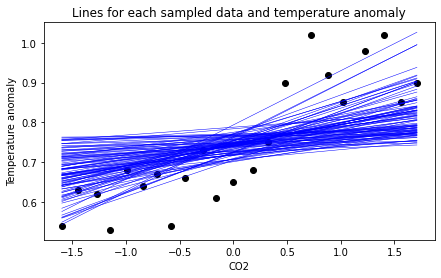

In [91]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = fit.stan_variable('beta_CO2')
alpha_humid = fit.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

Now the lines are more adjusted to actual data. There are less data point on the center and so there is less wide lines there. As the data is spread at the ends  so are the lines 

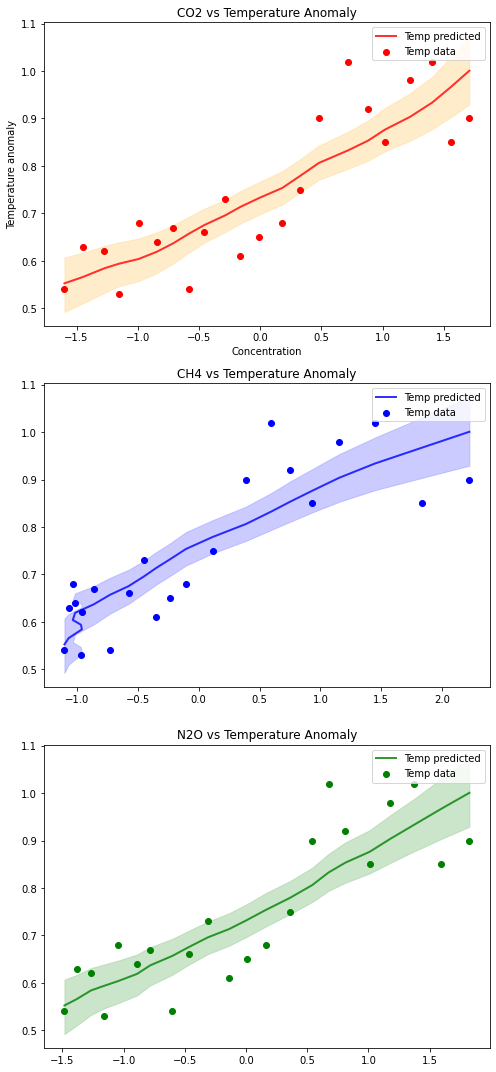

In [103]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

CO2 = np.array(df['CO2'])
CH4 = np.array(df['CH4'])
N2O = np.array(df['N2O'])
Temperature = np.array(df['Temperature'])
mu_CO2 = fit.stan_variable('mean')
mu_CH4 = fit.stan_variable('mean')
mu_N2O = fit.stan_variable('mean')


fig, ax = plt.subplots(3, 1, figsize=(7 ,15))

ax[0].fill_between(
    CO2,
    np.percentile(mu_CO2, 5, axis=0),
    np.percentile(mu_CO2, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('orange'))),
    alpha=0.5
)

ax[1].fill_between(
    CH4,
    np.percentile(mu_CH4, 5, axis=0),
    np.percentile(mu_CH4, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('blue'))),
    alpha=0.5
)

ax[2].fill_between(
    N2O,
    np.percentile(mu_N2O, 5, axis=0),
    np.percentile(mu_N2O, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('green'))),
    alpha=0.5
)

ax[0].plot(
    CO2,
    np.percentile(mu_CO2, 50, axis=0),
    color='red',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[1].plot(
    CH4,
    np.percentile(mu_CH4, 50, axis=0),
    color='blue',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[2].plot(
    N2O,
    np.percentile(mu_N2O, 50, axis=0),
    color='green',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)

ax[0].scatter(CO2, Temperature, color='red', label='Temp data')
ax[1].scatter(CH4, Temperature, color='blue', label='Temp data')
ax[2].scatter(N2O, Temperature, color='green', label='Temp data')

ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Temperature anomaly')


ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title('CO2 vs Temperature Anomaly')
ax[1].set_title('CH4 vs Temperature Anomaly')
ax[2].set_title('N2O vs Temperature Anomaly')
plt.tight_layout()
plt.show()



Shown output data is consistent with the provided data of temperatures anomaly. For each gases the output mean fits great.

### Marginal Distribution 

0.7803419999999998


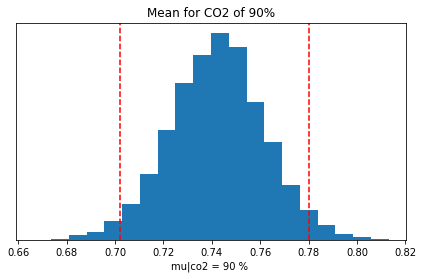

Mean: 0.74
95% confidence interval:  ['0.70', '0.78']


In [111]:
import arviz as az
alpha_post =  fit.stan_variable('alpha')
beta_post = fit.stan_variable('beta_CO2')
mu_post = fit.stan_variable('mean')

mu90 = alpha_post+beta_post*(np.mean(df['CO2']))
mu_95p = az.hdi(mu90,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu90,bins=20,density=True)
plt.axvline(mu_95p[0], linestyle = '--', color = 'r')
plt.axvline(mu_95p[1], linestyle = '--', color = 'r')
ax.set_title('Mean for CO2 of 90%')
ax.set_yticks(())
ax.set_xlabel('mu|co2 = 90 % ')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu90)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu90,.95)])

We can see form above histogram that on 90% propability the temperature anomaly will be in range 0.7 and 0.78. Th eother gases are not gonna be checked due to the similar data with CO2

# Model Student_t distribution for CO2 

# Prior Student_t CO2

In [49]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df))}

In [50]:
model_ppc6_p=CmdStanModel(stan_file='root/stan_files/temp6_ppc_prior.stan')
R = 1000
sim6=model_ppc6_p.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

ValueError: no such file /root/stan_files/temp6_ppc_prior.stan

In [ ]:
df_6_p = sim6.draws_pd()
df_6_p.head()

In [ ]:
temperature = df_6_p.loc[:, 'temperature[1]':'temperature[22]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(temperature, q, axis=1)
data_quantiles = np.quantile(df.Temperature, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.ylim(0,1.5)
plt.legend()
plt.show()

In [ ]:
df_6_p.describe()

In [ ]:
years = df['year'].values
observed_lambda = df['Temperature'].values
sampled_lambdas = df_6_p.loc[:, 'temperature[1]':'temperature[22]'].values

In [ ]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(15, 40))
axes = axes.flatten()
print(axes)

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[i + 1], density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('temperature')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

# Fit to CO2

In [ ]:
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2_centred.values[:N], 'temp': df.Temperature.values[:N]}

In [51]:
%%writefile root/stan_files/temp6_ppc.stan
data {
  int<lower=0> N; // number of data points
  vector[N] CO2;
  vector[N] temp;
}
parameters {
  real<lower=0> alpha;
  real<lower=0> beta_CO2;
  real<lower=0> sigma;
  real<lower=1, upper=80> nu;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta_CO2 * CO2;
}
model {
  nu ~ gamma(2, 0.1); // found this online: Juarez and Steel(2010)
  temp ~ student_t(nu, mu, sigma);
  alpha ~ normal(0.7, 0.1);
  beta_CO2 ~ normal(0, 0.1);
  sigma ~ normal(0.1,0.05);

}
generated quantities {
    vector[N] temp_i;
    vector[N] temp_student;
    for (i in 1:N) {
        temp_i[i] = student_t_rng(nu,mu[i],sigma);
        temp_student[i] = student_t_lpdf(temp[i] | nu, mu[i], sigma);
    }
}

Writing root/stan_files/temp6_ppc.stan


In [53]:
model_ppc6=CmdStanModel(stan_file='root/stan_files/temp6_ppc.stan')
fit6=model_ppc6.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp6_ppc.stan to exe file /root/stan_files/temp6_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp6_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [54]:
df_6 = fit6.draws_pd()
df_6.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_CO2,sigma,...,temp_student[13],temp_student[14],temp_student[15],temp_student[16],temp_student[17],temp_student[18],temp_student[19],temp_student[20],temp_student[21],temp_student[22]
0,34.2776,1.000000,0.584935,2.0,3.0,0.0,-30.7904,0.730990,0.121883,0.083497,...,1.15063,1.51526,0.665088,-1.08468,1.056660,1.54592,0.822651,0.554333,1.16919,1.43097
1,33.0102,0.867253,0.584935,2.0,3.0,0.0,-32.2966,0.725614,0.132582,0.072809,...,1.17928,1.62995,0.525473,-1.27375,1.071660,1.65538,0.848721,0.575547,0.99477,1.38593
2,33.7043,0.995425,0.584935,2.0,3.0,0.0,-32.6183,0.736143,0.123492,0.070233,...,1.06220,1.63295,0.609695,-1.41040,1.117300,1.69439,0.829420,0.500977,1.05512,1.46661
3,31.1441,0.911600,0.584935,3.0,7.0,0.0,-31.0310,0.727493,0.098527,0.067024,...,1.22532,1.72880,0.139443,-1.86409,0.530436,1.67799,0.004372,-0.458721,1.61529,1.73868
4,29.3255,0.977025,0.584935,3.0,7.0,0.0,-28.8592,0.738884,0.086432,0.069759,...,1.05551,1.64534,0.304475,-1.43077,0.563381,1.61555,0.025721,-0.411021,1.61074,1.65957


In [55]:
df_6.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_CO2,sigma,...,temp_student[13],temp_student[14],temp_student[15],temp_student[16],temp_student[17],temp_student[18],temp_student[19],temp_student[20],temp_student[21],temp_student[22]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,32.578992,0.930105,0.594758,2.615500,6.007500,0.0,-30.638295,0.741107,0.126762,0.085887,...,0.974893,1.423222,0.795864,-0.828923,1.151633,1.449289,0.957150,0.728710,0.862725,1.184499
std,1.480208,0.086039,0.018890,0.506186,1.740891,0.0,2.014598,0.018415,0.018252,0.014961,...,0.227651,0.169822,0.288300,0.674282,0.258287,0.186191,0.353218,0.445992,0.440535,0.340687
min,24.162500,0.202051,0.568619,1.000000,1.000000,0.0,-34.388100,0.667707,0.060225,0.050050,...,-0.106882,0.821664,-0.566332,-3.413620,-0.125888,0.684319,-0.766596,-1.308070,-1.436920,-0.709325
25%,31.820975,0.899397,0.580856,2.000000,7.000000,0.0,-32.134275,0.729010,0.114566,0.075193,...,0.844439,1.311748,0.633591,-1.247410,1.006580,1.330150,0.760447,0.474284,0.619163,1.016747
50%,32.913450,0.960225,0.598545,3.000000,7.000000,0.0,-30.962200,0.741121,0.126503,0.084051,...,0.995984,1.433155,0.820883,-0.775978,1.179325,1.464130,0.999518,0.779685,0.939480,1.247205
75%,33.685950,0.991041,0.612446,3.000000,7.000000,0.0,-29.523550,0.753231,0.138995,0.094368,...,1.134375,1.539600,0.998807,-0.343442,1.329963,1.578270,1.208427,1.054220,1.174697,1.415705
max,34.635600,1.000000,0.613323,3.000000,15.000000,0.0,-21.813100,0.812314,0.197590,0.163415,...,1.576890,1.936840,1.546130,0.750072,1.829880,1.978320,1.746850,1.686610,1.804740,1.888100


[ 1.59413   0.772399  1.26259   1.47594   0.943755  1.59411   1.51292
  0.568136  1.66494   1.48327   0.811097  1.10965   1.17928   1.62995
  0.525473 -1.27375   1.07166   1.65538   0.848721  0.575547  0.99477
  1.38593 ]


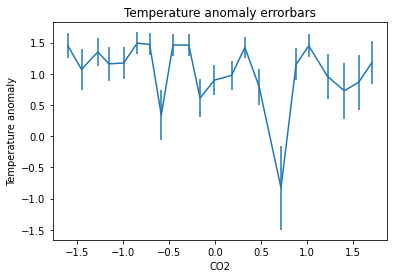

In [56]:
# 6. Plot results
temperature = df_6.loc[:, 'temp_student[1]':f'temp_student[{N}]'].values
y = temperature.mean(axis=0)
x = data_fit['CO2']
yerr = temperature.std(axis=0)
print(temperature[1])

plt.errorbar(x, y, yerr)
plt.xlabel('CO2')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly errorbars')
plt.show()


# Student_t distribution for all

# prior

In [57]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df)),'CH4':np.linspace(df.CH4.min(),df.CH4.max(),len(df)),'N2O':np.linspace(df.N2O.min(),df.N2O.max(),len(df))}

In [65]:
%%writefile root/stan_files/temp7_ppc_prior.stan
data {
  int<lower=0> N;
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
}

generated quantities {
  real sigma = exponential_rng(0.067);
  real nu = gamma_rng(2, 0.1);
  real alpha = normal_rng(0.7, 0.1);
  real beta_CO2 = normal_rng(0, 0.1);
  real beta_CH4 = normal_rng(0, 0.1);
  real beta_N2O = normal_rng(0, 0.1);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = student_t_rng(nu, alpha + beta_CO2 * CO2[i], sigma);
  }
}


Overwriting root/stan_files/temp7_ppc_prior.stan


In [66]:
model_ppc7_p=CmdStanModel(stan_file='root/stan_files/temp7_ppc_prior.stan')
R = 1000
sim7=model_ppc7_p.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)
df_7_p = sim7.draws_pd()
df_7_p.describe()

INFO:cmdstanpy:compiling stan file /root/stan_files/temp7_ppc_prior.stan to exe file /root/stan_files/temp7_ppc_prior
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp7_ppc_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,sigma,nu,alpha,beta_CO2,beta_CH4,beta_N2O,temperature[1],temperature[2],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,14.668250,19.755320,0.698571,-0.002107,0.002479,-0.001018,0.366110,-0.497378,...,0.813750,-10.450802,-1.319268,1.029675,-1.145926,0.523049,3.433163e+05,-0.895596,-0.113193,0.249120
std,0.0,0.0,15.158312,14.331413,0.098524,0.097834,0.100048,0.099001,22.563731,28.997442,...,24.171133,368.317551,47.215900,23.117344,26.054897,22.098537,1.085664e+07,23.564711,21.519224,25.751538
min,0.0,0.0,0.005729,0.441051,0.402443,-0.313683,-0.339781,-0.343639,-199.708000,-506.148000,...,-186.744000,-11615.800000,-1194.810000,-229.160000,-253.508000,-222.840000,-6.818030e+02,-185.460000,-149.951000,-191.564000
25%,0.0,0.0,3.841133,9.542832,0.634416,-0.069680,-0.062719,-0.069271,-3.921765,-5.063130,...,-4.938078,-4.035778,-6.173095,-4.283057,-6.672372,-4.799070,-4.964728e+00,-5.550478,-5.346260,-5.313987
50%,0.0,0.0,9.735230,16.184150,0.701205,-0.007422,0.003986,0.000507,0.685448,0.658192,...,0.584083,0.815057,0.482720,0.752978,0.488878,0.769632,5.789340e-01,0.400956,0.412082,0.617094
75%,0.0,0.0,20.107250,26.197275,0.761856,0.060635,0.072740,0.062332,6.200750,6.495770,...,6.516335,6.175897,6.324725,6.733505,5.440395,7.080707,5.804560e+00,5.320360,5.540890,6.151475
max,0.0,0.0,97.678100,110.200000,1.011310,0.295066,0.295962,0.302682,128.951000,294.838000,...,175.227000,383.614000,224.655000,136.977000,186.863000,140.302000,3.433170e+08,178.268000,147.801000,204.399000


In [60]:
df_7_p = sim7.draws_pd()
df_7_p.head()

,lp__,accept_stat__,sigma,nu,alpha,beta_CO2,beta_CH4,beta_N2O,temperature[1],temperature[2],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
0,0.0,0.0,68.97160,10.83360,0.693634,-0.127227,0.012759,-0.138942,17.94930,50.172600,...,-19.49900,68.79860,47.18720,-64.49050,-95.56320,48.12730,-140.45800,46.055000,70.11850,-9.54228
1,0.0,0.0,4.83888,20.63350,0.643012,0.104238,0.116276,0.188285,9.16563,1.627640,...,1.13098,5.19955,8.83696,3.53492,-8.73515,-7.52636,3.10609,0.871095,7.93969,5.10913
2,0.0,0.0,26.37580,26.19870,0.650050,0.024688,-0.058932,-0.001650,27.76750,0.054258,...,-2.73867,-15.95880,21.82100,-4.97582,12.60720,-29.39130,32.74990,32.373500,-18.31500,-55.39540
3,0.0,0.0,52.54490,10.71170,0.715188,0.058156,0.012169,-0.106303,2.75283,14.385900,...,72.65420,4.40897,-35.99900,87.16780,16.24740,-26.17290,-2.74351,-21.766400,15.50490,32.27080
4,0.0,0.0,41.06190,6.71546,0.700992,0.099502,0.044901,-0.003987,8.48483,-8.265710,...,115.39100,-13.92370,10.30050,-15.74840,-47.67650,-10.28030,-5.96688,-20.751100,6.58086,22.25730


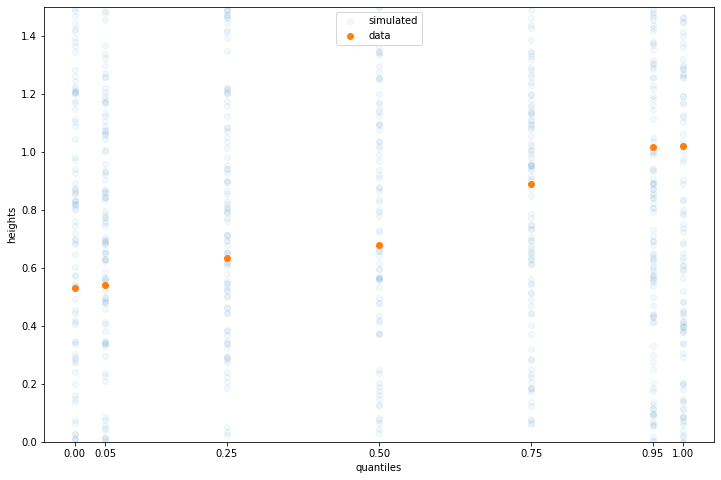

In [61]:
temperature = df_7_p.loc[:, 'temperature[1]':'temperature[22]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(temperature, q, axis=1)
data_quantiles = np.quantile(df.Temperature, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.ylim(0,1.5)
plt.legend()
plt.show()

In [62]:
df_7_p.describe()

,lp__,accept_stat__,sigma,nu,alpha,beta_CO2,beta_CH4,beta_N2O,temperature[1],temperature[2],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,14.668250,19.755320,0.698571,-0.002107,0.002479,-0.001018,0.364887,-0.498370,...,0.815317,-10.449076,-1.317241,1.031940,-1.143427,0.525775,3.433163e+05,-0.892402,-0.109768,0.252779
std,0.0,0.0,15.158312,14.331413,0.098524,0.097834,0.100048,0.099001,22.554884,28.996213,...,24.167731,368.324156,47.215460,23.112539,26.057380,22.097254,1.085664e+07,23.568270,21.518641,25.736101
min,0.0,0.0,0.005729,0.441051,0.402443,-0.313683,-0.339781,-0.343639,-199.768000,-505.894000,...,-186.748000,-11616.000000,-1194.870000,-229.342000,-253.468000,-222.951000,-6.820620e+02,-185.890000,-149.907000,-191.659000
25%,0.0,0.0,3.841133,9.542832,0.634416,-0.069680,-0.062719,-0.069271,-3.929708,-5.065218,...,-4.970503,-4.055120,-6.037318,-4.489440,-6.630387,-4.810890,-4.927282e+00,-5.603360,-5.434895,-5.416932
50%,0.0,0.0,9.735230,16.184150,0.701205,-0.007422,0.003986,0.000507,0.646423,0.657241,...,0.572084,0.824399,0.472369,0.798285,0.516232,0.838294,6.491285e-01,0.344167,0.331211,0.633889
75%,0.0,0.0,20.107250,26.197275,0.761856,0.060635,0.072740,0.062332,6.122958,6.487653,...,6.525382,6.057215,6.336790,6.803113,5.628345,7.211245,5.784873e+00,5.336550,5.434200,6.103590
max,0.0,0.0,97.678100,110.200000,1.011310,0.295066,0.295962,0.302682,128.826000,294.832000,...,175.122000,383.519000,224.499000,136.838000,186.651000,140.106000,3.433170e+08,178.566000,147.589000,204.129000


In [63]:
years = df['year'].values
observed_lambda = df['Temperature'].values
sampled_lambdas = df_7_p.loc[:, 'temperature[1]':'temperature[22]'].values

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]


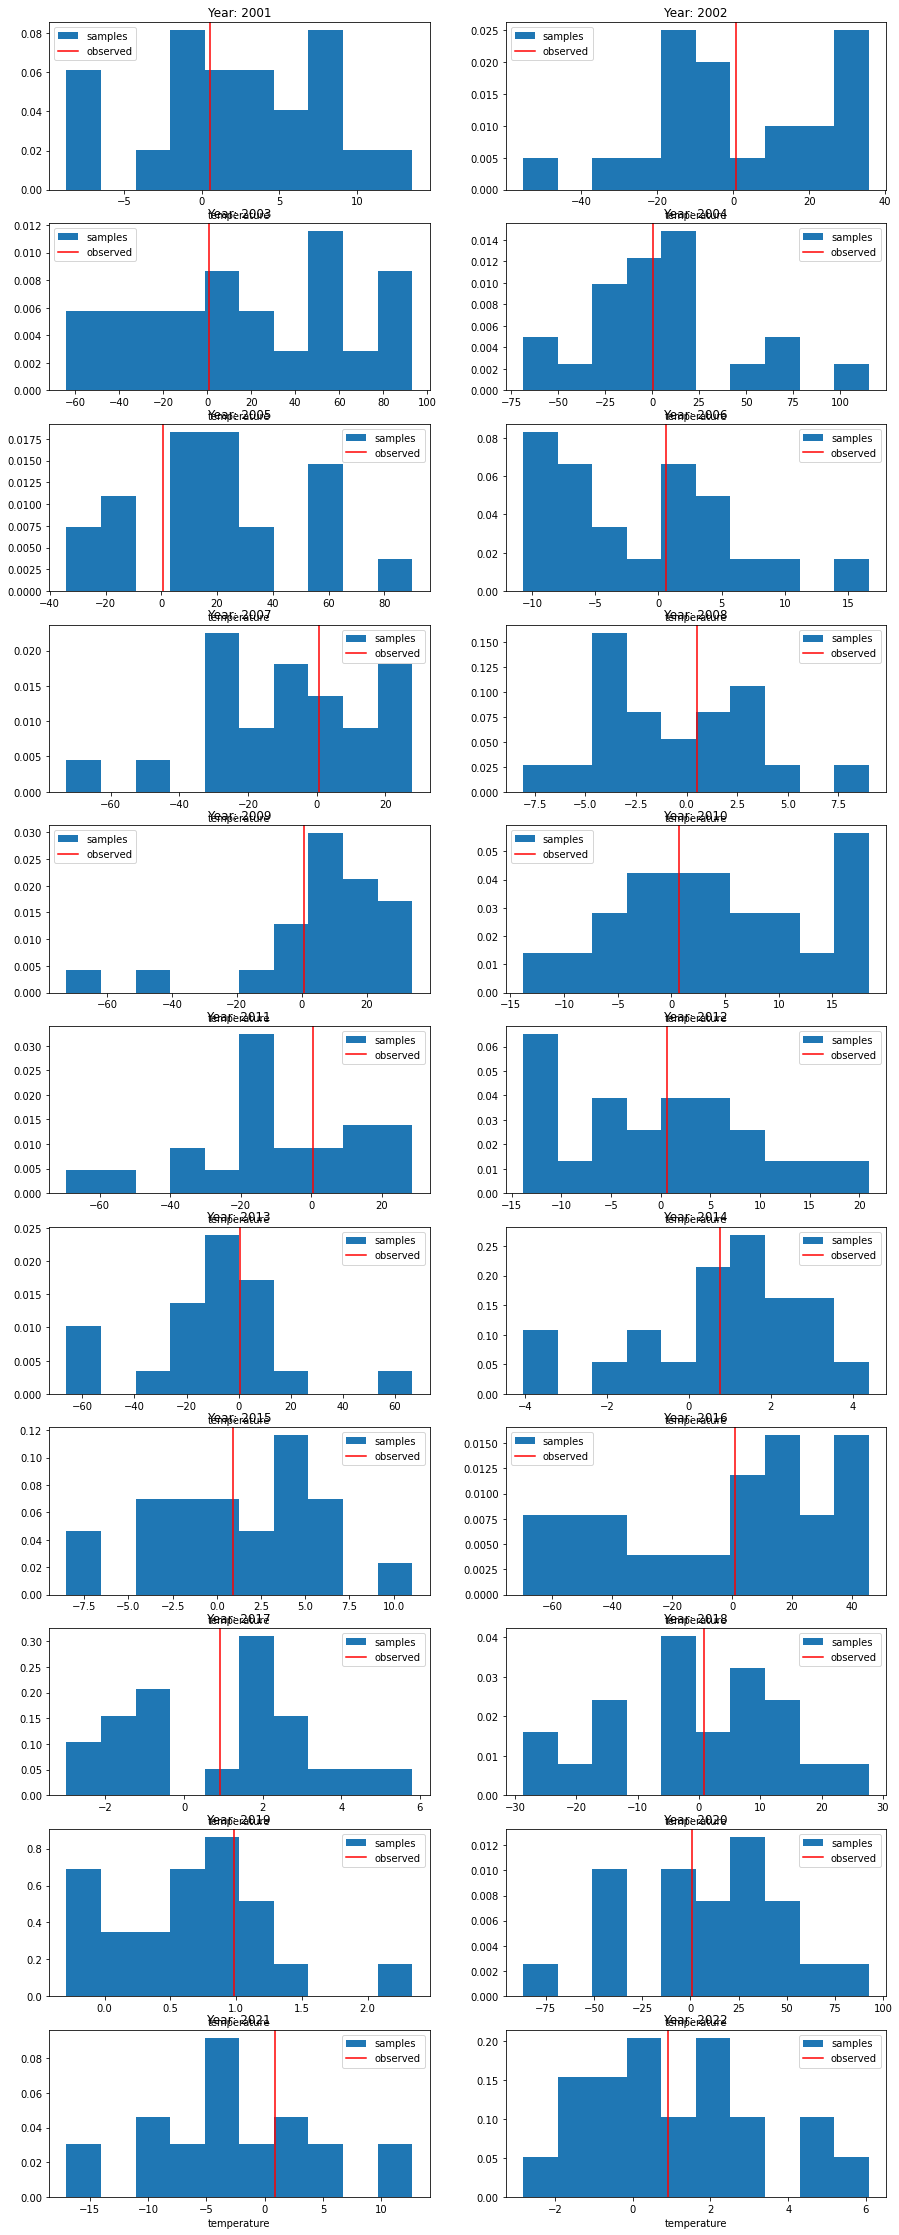

In [64]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(15, 40))
axes = axes.flatten()
print(axes)

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[i + 1], density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('temperature')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

# fit

In [ ]:
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2_centred.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4_centred.values[:N], 'N2O': df.N2O_centred.values[:N]}

In [ ]:
model_ppc7=CmdStanModel(stan_file='stan_files/temp7_ppc.stan')
fit7=model_ppc7.sample(data=data_fit,seed=28052020)

In [ ]:
df_7 = fit7.draws_pd()
df_7.head()

In [ ]:
df_7.describe()

In [ ]:
temperature = df_7.loc[:, 'temp_student[1]':f'temp_student[{N}]'].values
y = temperature.mean(axis=0)
x_CO2 = data_fit['CO2']
x_CH4 = data_fit['CH4']
x_N2O = data_fit['N2O']
yerr = temperature.std(axis=0)

# Wykres
plt.errorbar(x_CO2, y, yerr, label='CO2')
plt.errorbar(x_CH4, y, yerr, label='CH4')
plt.errorbar(x_N2O, y, yerr, label='N2O')
plt.xlabel('Concentration')
plt.ylabel('Temperature anomaly')
plt.title('Temperature anomaly errorbars')
plt.legend()
plt.show()